In [505]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import special
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from itertools import combinations as combs
from sklearn.linear_model import Ridge, Lasso
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split
plt.rcParams["font.family"] = "Times New Roman"

In [506]:
def normalize_arr(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    nrm = (arr-mean)/std
    return nrm
    
def yearly_avg_over_months(yr_arr,arr):
    n_yr = np.unique(yr_arr)
    avg_val = []
    for i in range(len(n_yr)):
        avg_val.append(np.nanmean(arr[i*12:(i+1)*12]))
    return np.stack((n_yr,avg_val),axis = 1)

def arr_loc(arr,val):
    index = 0
    for i in range(len(arr)):
        index = i
        if int(arr[i]) == int(val):
            break
           
    return index

## Generate dataframe for input variables/features in the range 1996-2012

###  Varibales considered - (1) Total Biomass availability,  (2) Total biomass anomaly,   (3) Sea level,   (4) Salinity,  (5) PDO,  (6) Sea Surface Temperature,  (7) Avg Fraser river flow,  (8) Killer whale,  (9) Seal population, (10) Recreational catches

In [507]:
start_date = 1997
end_date = 2012

# Reading the data_files
#(1) read zooplankton total biomass data
Biomass_file = pd.read_excel('Data/ZooPlanktonPerryData.xlsx','1. Zooplankton Biomass data') 

#(2) read zooplankton anomaly data
Biomass_anamoly_file = pd.read_excel('Data/ZooPlanktonPerryData.xlsx','3. Zooplankton anomalies')  

#(3) read sea level data
Sl_file_campbell = pd.read_excel('Pred_env_data/SeaLevel_Campbell_River1323.xlsx',header=None)
Sl_file_cherry = pd.read_excel('Pred_env_data/SeaLevel_Cherry_annualMean.xlsx',header=None)
Sl_file_atkinson = pd.read_excel('Pred_env_data/SeaLevel_Point_Atkinson193.xlsx',header=None)
Sl_file_angeles = pd.read_excel('Pred_env_data/SeaLevel_Port_Angeles2127.xlsx',header=None)

#(4) read sea salinity data
Salinity_file = pd.read_excel('Pred_env_data/Entrance_island_salinity.xlsx') 

#(5) read Pacific decadal oscillation(PDO) data
Pdo_file = pd.read_excel('Pred_env_data/pdo.xlsx','pdo')  

#(6) read sea surface temperature
SST_file = pd.read_excel('Pred_env_data/SST_data.xlsx', 'SST data')  

#(7) read Fraser river flow data
Flow_rate_file = pd.read_excel('Pred_env_data/Fraser_flow_rate.xlsx','Flow rate')  

#(8) read Killer Whale data
Whale_file = pd.read_excel('Pred_env_data/killerwhales_1970to2020.xlsx','killerwhales_1970to2020') 

#(9) read harbour seal population data
Seal_file = pd.read_excel('Pred_env_data/harbourseals_1970to2020.xlsx','harbourseals_1970to2020')  

#(10) read recreational catch data
RC_file = pd.read_excel('Pred_env_data/Recreational_catches_cleaned_SOG_1953_2012.xlsx')  


## Selecting dataframes in the range 1996-2012
We will replace nan values with a simple imputer(mean) method. Note to Sean, Aycin, Andrew - Do we need to use
multivariate/iterative imputer for this, or a simple mean imputation should be sufficient?

## Feeding variables

Biomass, biomass anomaly

In [508]:
df_biomass = Biomass_file.loc[(Biomass_file['yr'] >= start_date) & (Biomass_file['yr'] <= end_date)]
df_biom_anom = Biomass_anamoly_file.loc[(Biomass_anamoly_file['Year'] >= start_date) & (Biomass_anamoly_file['Year'] <= end_date)]

#We will only work with total biomass and total biomass anomaly here

df_biomass_clean = pd.DataFrame({'Year':df_biomass['yr'],'Total Biomass':df_biomass['Total.Biomass']})
df_biom_anom_clean = pd.DataFrame({'Year':df_biom_anom['Year'],'Total Biomass anomaly':df_biom_anom['TotBiom']})

df_biomass_clean = df_biomass_clean.groupby(['Year']).mean()

df_feeding_factors = pd.merge(df_biomass_clean,df_biom_anom_clean, on = 'Year',how = 'outer')
#print(df_biomass_clean)
#print(df_biom_anom_clean)
print(df_feeding_factors)

    Year  Total Biomass  Total Biomass anomaly
0   1997      71.212723               0.100896
1   1998     105.522363               0.310248
2   1999     156.692799               0.271163
3   2000     130.563055               0.186406
4   2001     102.394193               0.112293
5   2002      71.626773               0.048593
6   2003      61.066670              -0.102757
7   2004      39.438141              -0.179500
8   2005      21.697433              -0.260425
9   2006      58.623723              -0.088966
10  2007      48.614769              -0.153116
11  2008     151.181537              -0.022051
12  2009     148.035048              -0.043890
13  2010     121.507428               0.003037
14  2011     108.806579               0.240546
15  2012      76.453393               0.112064


# Environmental variables

Sea Salinity

In [509]:
#Sea salinity is provided monthly, we will calculate yearly average. Also, nonexistent data is marked by -999.99

df_salinity = Salinity_file.replace(999.99,np.nan)
df_salinity_yr = df_salinity['YEAR']
df_salinity_val = df_salinity.drop(['YEAR'],axis=1).mean(axis = 1)
df_sea_salinity = pd.DataFrame({'Year':df_salinity_yr,'Avg Sea Salinity':df_salinity_val})
df_sea_salinity = df_sea_salinity.loc[(df_sea_salinity['Year'] >= start_date) & (df_sea_salinity['Year'] <= end_date)]
df_sea_salinity.reset_index(drop = True, inplace = True)
print(df_sea_salinity)

    Year  Avg Sea Salinity
0   1997         25.359167
1   1998         27.243333
2   1999         26.195833
3   2000         27.405833
4   2001         28.385000
5   2002         27.663333
6   2003         27.967273
7   2004         27.438333
8   2005         27.265000
9   2006         28.180833
10  2007         26.918333
11  2008         27.835833
12  2009         27.345000
13  2010         26.639167
14  2011         24.715455
15  2012         25.620833


Average Sea level

In [510]:
# Sea levels for nonexistent data points are marked with -99999 we will replace them with mean

df_sl_campbell = Sl_file_campbell.drop(columns = [2,3]).replace(-99999,np.nan)
df_sl_cherry = Sl_file_cherry.drop(columns = [2,3]).replace(-99999,np.nan)
df_sl_atkinson = Sl_file_atkinson.drop(columns = [2,3]).replace(-99999,np.nan)
df_sl_angeles = Sl_file_angeles.drop(columns = [2,3]).replace(-99999,np.nan)

df_sl_campbell = df_sl_campbell.fillna(df_sl_campbell[1].mean()).loc[(df_sl_campbell[0] >= start_date) & (df_sl_campbell[0] <= end_date)]
df_sl_cherry = df_sl_cherry.fillna(df_sl_cherry[1].mean()).loc[(df_sl_cherry[0] >= start_date) & (df_sl_cherry[0] <= end_date)]
df_sl_atkinson = df_sl_atkinson.fillna(df_sl_atkinson[1].mean()).loc[(df_sl_atkinson[0] >= start_date) & (df_sl_atkinson[0] <= end_date)]
df_sl_angeles = df_sl_angeles.fillna(df_sl_angeles[1].mean()).loc[(df_sl_angeles[0] >= start_date) & (df_sl_angeles[0] <= end_date)]

df_sl_campbell_clean = df_sl_campbell.rename(columns={0: 'Year', 1: 'SeaLevel_Campbell'})
df_sl_cherry_clean = df_sl_cherry.rename(columns={0: 'Year', 1: 'SeaLevel_Cherry'})
df_sl_atkinson_clean = df_sl_atkinson.rename(columns={0: 'Year', 1: 'SeaLevel_Atkinson'})
df_sl_angeles_clean = df_sl_angeles.rename(columns={0: 'Year', 1: 'SeaLevel_Angeles'})
df_sl_merged = pd.merge(df_sl_campbell_clean,df_sl_cherry_clean, on = 'Year', how = 'outer')
df_sl_merged = pd.merge(df_sl_merged,df_sl_atkinson_clean, on = 'Year', how = 'outer')
df_sl = pd.merge(df_sl_merged,df_sl_angeles_clean, on = 'Year', how = 'outer')

df_sl['Avg Sea Levels']= df_sl.iloc[:,1:].mean(axis=1, skipna=True)
print(df_sl)

    Year  SeaLevel_Campbell  SeaLevel_Cherry  SeaLevel_Atkinson  \
0   1997             7126.0           7081.0        7050.703704   
1   1998             7077.0           7065.0        7098.000000   
2   1999             7013.0           7008.0        7072.000000   
3   2000             6987.0           6982.0        7034.000000   
4   2001             6975.0           6965.0        7025.000000   
5   2002             6984.0           6990.0        7045.000000   
6   2003             7028.0           7034.0        7079.000000   
7   2004             7017.0           7024.0        7072.000000   
8   2005             7036.0           7034.0        7084.000000   
9   2006             7047.0           7032.0        7097.000000   
10  2007             7017.0           6966.0        7058.000000   
11  2008             7006.0           6962.0        7033.000000   
12  2009             7008.0           6976.0        7043.000000   
13  2010             7090.0           7043.0        7114.00000

PDO, Sea Surface Temperature, Flow Rate

In [511]:
df_pdo = Pdo_file.loc[(Pdo_file['year'] >= start_date) & (Pdo_file['year'] <= end_date)]
df_pdo_clean = df_pdo.rename(columns={'year':'Year'})
df_pdo_avg = df_pdo_clean.groupby(['Year']).mean()
df_pdo_avg = df_pdo_avg.drop(columns = ['date','month'])

df_sst = SST_file.loc[(SST_file['Year'] >= start_date) & (SST_file['Year'] <= end_date)].drop(columns = ['Sl no','Month','Day'])
df_sst_avg = df_sst.groupby(['Year']).mean()

df_flow_rate = Flow_rate_file[(Flow_rate_file['Year'] >= start_date) & (Flow_rate_file['Year'] <= end_date) &(Flow_rate_file['PARAM'] == 1)]
df_flow_rate = df_flow_rate.drop(columns = [' ID','PARAM','MM--DD','SYM','MM--DD.1','SYM.1'])
df_flow_rate['Avg flow rate'] = 0.5*(df_flow_rate['MAX']+df_flow_rate['MIN'])
df_flow_rate.rename(columns = {'MAX':'Max flow rate','MIN':'Min flow rate'},inplace = True)
df_flow_rate.reset_index(drop = True, inplace = True)

Merging Sea salinity, Avg Sea level, PDO, Sea surface temperature and Avg Flow rate into one dataframe 

In [512]:
#print(df_flow_rate)
#print(df_sst_avg)
#print(df_pdo_avg)

df_env_factors = pd.merge(df_sea_salinity,df_sl[['Year','Avg Sea Levels']],on = 'Year',how = 'outer')
df_env_factors = pd.merge(df_env_factors,df_pdo_avg,on = 'Year',how = 'outer')
df_env_factors = pd.merge(df_env_factors,df_sst_avg, on='Year',how = 'outer')
df_env_factors = pd.merge(df_env_factors, df_flow_rate[['Year','Avg flow rate']], on = 'Year', how = 'outer')
print(df_env_factors)

    Year  Avg Sea Salinity  Avg Sea Levels       pdo        SST  Avg flow rate
0   1997         25.359167     7073.925926  1.316667  10.236920         6044.0
1   1998         27.243333     7062.500000 -0.478333   9.880789         3655.0
2   1999         26.195833     7011.250000 -1.843333   9.353840         5823.5
3   2000         27.405833     6979.500000 -1.125833   9.429773         4235.0
4   2001         28.385000     6968.500000 -1.134167  10.284261         3809.0
5   2002         27.663333     6983.750000 -0.439167  10.648880         5545.5
6   2003         27.967273     7026.250000  0.381667   9.851023         3886.0
7   2004         27.438333     7014.000000 -0.224167   9.671527         3605.0
8   2005         27.265000     7029.000000 -0.188333  10.114719         4132.5
9   2006         28.180833     7038.750000 -0.350833   9.611567         3850.0
10  2007         26.918333     6989.000000 -0.702500  10.262374         5680.0
11  2008         27.835833     6977.500000 -1.663333

## Predatory variables

Killer whale and Harbour seal population, RC catch

In [513]:
df_whale = Whale_file.loc[(Whale_file['Year'] >= start_date) & (Whale_file['Year'] <= end_date)].drop(columns = ['SRKW','srkwSource','nrkwSource'])
df_seal = Seal_file.loc[(Seal_file['year'] >= start_date) & (Seal_file['year'] <= end_date)].drop(columns = ['nonSogNt','bcNt']).rename(columns={'year':'Year'})
df_rc_catch = RC_file.loc[(RC_file['Year'] >= start_date) & (RC_file['Year'] <= end_date)].iloc[:,1:]

df_whale.reset_index(drop = True, inplace = True)
df_seal.reset_index(drop = True, inplace = True)
df_rc_catch.reset_index(drop = True,inplace = True)

df_pred_factors = pd.merge(df_seal,df_whale, on = 'Year',how = 'outer')
df_pred_factors = pd.merge(df_pred_factors,df_rc_catch,on='Year',how = 'outer')
df_pred_factors.rename(columns = {'sogNt':'Harbour seal','NRKW':'Killer whale'},inplace = True)
df_input_variables = pd.merge(df_feeding_factors,df_env_factors,on = 'Year', how = 'outer')
df_input_variables = pd.merge(df_input_variables,df_pred_factors,on = 'Year', how = 'outer')
df_input_variables

,Year,Total Biomass,Total Biomass anomaly,Avg Sea Salinity,Avg Sea Levels,pdo,SST,Avg flow rate,Harbour seal,Killer whale,Chinook catch,Coho catch
0,1997,71.212723,0.100896,25.359167,7073.925926,1.316667,10.236920,6044.0,39187,218.0,154268,213163
1,1998,105.522363,0.310248,27.243333,7062.500000,-0.478333,9.880789,3655.0,39190,216.0,160780,16335
2,1999,156.692799,0.271163,26.195833,7011.250000,-1.843333,9.353840,5823.5,39190,216.0,185093,47758
3,2000,130.563055,0.186406,27.405833,6979.500000,-1.125833,9.429773,4235.0,39190,208.0,138164,36707
4,2001,102.394193,0.112293,28.385000,6968.500000,-1.134167,10.284261,3809.0,39190,200.0,218707,213302
5,2002,71.626773,0.048593,27.663333,6983.750000,-0.439167,10.648880,5545.5,39190,203.0,350788,183885
6,2003,61.066670,-0.102757,27.967273,7026.250000,0.381667,9.851023,3886.0,39190,204.0,494653,345421
7,2004,39.438141,-0.179500,27.438333,7014.000000,-0.224167,9.671527,3605.0,39190,220.0,606127,299931
8,2005,21.697433,-0.260425,27.265000,7029.000000,-0.188333,10.114719,4132.5,39190,230.0,541544,283672
9,2006,58.623723,-0.088966,28.180833,7038.750000,-0.350833,9.611567,3850.0,39190,239.0,306738,127230


# Building Lasso model with the entire data (1996-2012) as training and CV set

### Creating dataframe with input variables



In [514]:
X = df_input_variables[['Total Biomass','Avg Sea Levels','Avg Sea Salinity','pdo','Harbour seal','Killer whale','Chinook catch','Coho catch']]
print(X)
scaler = StandardScaler()
x_nrm = scaler.fit_transform(X) #These will be our input features

    Total Biomass  Avg Sea Levels  Avg Sea Salinity       pdo  Harbour seal  \
0       71.212723     7073.925926         25.359167  1.316667         39187   
1      105.522363     7062.500000         27.243333 -0.478333         39190   
2      156.692799     7011.250000         26.195833 -1.843333         39190   
3      130.563055     6979.500000         27.405833 -1.125833         39190   
4      102.394193     6968.500000         28.385000 -1.134167         39190   
5       71.626773     6983.750000         27.663333 -0.439167         39190   
6       61.066670     7026.250000         27.967273  0.381667         39190   
7       39.438141     7014.000000         27.438333 -0.224167         39190   
8       21.697433     7029.000000         27.265000 -0.188333         39190   
9       58.623723     7038.750000         28.180833 -0.350833         39190   
10      48.614769     6989.000000         26.918333 -0.702500         39190   
11     151.181537     6977.500000         27.835833 

### Creating data frame with Target variable - salmon viability data

In [515]:

# Target variable, Salmon viability data
Salmon_file = pd.read_excel('Data/ZooPlanktonPerryData.xlsx','5. Salmon marine survivals') 
#print(Salmon_file)
for i in Salmon_file.columns[Salmon_file.isnull().any(axis=0)]:  
    Salmon_file[i].fillna(Salmon_file[i].mean(),inplace=True)
    
df_salmon_viab = Salmon_file.loc[(Salmon_file['Ocean Entry Year'] >= start_date) & (Salmon_file['Ocean Entry Year'] <= end_date)].rename(columns = {'Ocean Entry Year':'Year'}).reset_index(drop = True)
#print(df_salmon_viab)


### Building hyperparameter search space and grid search object

In [516]:
alphas = np.logspace(-5, -1, num=100001)

hp_space = {"alpha" : alphas}
lasso = Lasso()
gscv = GridSearchCV(estimator = lasso, param_grid = hp_space, 
                    scoring='neg_root_mean_squared_error', 
                    refit = "r2",
                    cv=3,verbose=0)

### Building Lasso model for Cowichan chinook species

In [517]:
cc_viab = df_salmon_viab['Cowichan Chinook'].to_numpy()  # This is the target variable
cc_viab_logit = special.logit(cc_viab)
y_cc = (cc_viab_logit-np.nanmean(cc_viab_logit))/np.nanstd(cc_viab_logit)
gscv.fit(x_nrm,y_cc)


GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-05, 1.00009211e-05, 1.00018422e-05, ...,
       9.99815810e-02, 9.99907901e-02, 1.00000000e-01])},
             refit='r2', scoring='neg_root_mean_squared_error')

In [453]:
print("Grid search best estimator for Cowichan chinook", gscv.best_estimator_)
print("Grid search best alpha for Cowichan chinook", gscv.best_params_['alpha'])
print("Optimized model score for Cowichan chinook", gscv.best_score_)

Grid search best estimator for Cowichan chinook Lasso(alpha=0.06530703998706806)
Grid search best alpha for Cowichan chinook 0.06530703998706806
Optimized model score for Cowichan chinook -1.257078268734809


Optimized mse 0.3378519554738858
Optimized lasso score 0.6621480445261142
[ 0.08076031  0.328314   -0.38781563 -0.39760228  0.          0.
  0.         -0.        ]


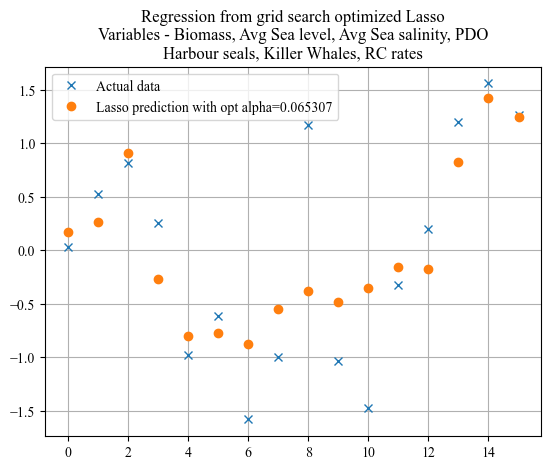

In [454]:
lasso.set_params(alpha=gscv.best_params_['alpha'])
lasso.fit(x_nrm, y_cc)
print("Optimized mse",mse(y_cc, lasso.predict(x_nrm)))
#print(lasso.alpha_)
print("Optimized lasso score",lasso.score(x_nrm,y_cc))
print(lasso.coef_)

plt.figure()
plt.title("Regression from grid search optimized Lasso\n"
           "Variables - Biomass, Avg Sea level, Avg Sea salinity, PDO\n"
           "Harbour seals, Killer Whales, RC rates")
plt.plot(y_cc,"x",label = 'Actual data')
plt.grid()
plt.plot(lasso.predict(x_nrm),"o",label = 'Lasso prediction with opt alpha=%0.6f'%gscv.best_params_['alpha'])
plt.legend(loc = 'best')
plt.savefig("Graphs/Cowichan_Chinook_prediction_grid_search_8_variables")

### Using LassoCV from sklearn linear model

In [469]:
lassocv = LassoCV(alphas = alphas, cv = 3, max_iter = 100000)
lassocv.fit(x_nrm, y_cc)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(x_nrm, y_cc)
print(mse(y_cc, lasso.predict(x_nrm)))
print(lassocv.alpha_)
print(lasso.score(x_nrm,y_cc))
print(lasso.coef_)

1.0
0.6906213498674949
0.0
[ 0.  0. -0.  0.  0.  0.]


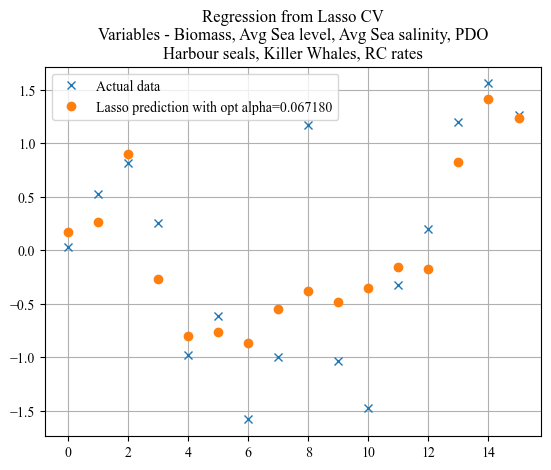

In [456]:
plt.figure()
plt.title("Regression from Lasso CV\n"
            "Variables - Biomass, Avg Sea level, Avg Sea salinity, PDO\n"
           "Harbour seals, Killer Whales, RC rates")
plt.plot(y_cc,"x",label = 'Actual data')
plt.grid()
plt.plot(lasso.predict(x_nrm),"o",label = 'Lasso prediction with opt alpha=%0.6f'%lassocv.alpha_)
plt.legend(loc = 'best')
plt.savefig("Graphs/Cowichan_Chinook_prediction_Lasso_CV_search_8_variables")

### Building Lasso model for Big Qualicum Coho species

#### Input variables considered - (1) Total Biomass availability,  (2) Total biomass anomaly,   (3) Sea level,   (4) Salinity,  (5) PDO,  (6) Sea Surface Temperature,  (7) Avg Fraser river flow,  (8) Killer whale,  (9) Seal population, (10) Recreational catches

In [518]:
df_input_variables = pd.merge(df_feeding_factors,df_env_factors,on = 'Year', how = 'outer')
df_input_variables = pd.merge(df_input_variables,df_pred_factors,on = 'Year', how = 'outer')
X = df_input_variables[['Total Biomass','Avg Sea Levels','Harbour seal','Killer whale','Chinook catch','Coho catch']]
#print(X)
scaler = StandardScaler()
x_nrm = scaler.fit_transform(X) #These will be our input features

#### Building grid search object

In [519]:
alphas = np.logspace(-4, -0, num=100001)

hp_space = {"alpha" : alphas}
lasso = Lasso()
gscv = GridSearchCV(estimator = lasso, param_grid = hp_space, 
                    scoring='neg_root_mean_squared_error', 
                    refit = "r2",
                    cv=3,verbose=0)

#### Target variable and grid search fit

In [520]:
bqc_viab = df_salmon_viab['Big Qualicum Coho'].to_numpy()  # This is the target variable
bqc_viab_logit = special.logit(bqc_viab)
y_bqc = (bqc_viab_logit-np.nanmean(bqc_viab_logit))/np.nanstd(bqc_viab_logit)
gscv.fit(x_nrm,y_bqc)


GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-04, 1.00009211e-04, 1.00018422e-04, ...,
       9.99815810e-01, 9.99907901e-01, 1.00000000e+00])},
             refit='r2', scoring='neg_root_mean_squared_error')

In [500]:
print("Grid search best estimator for Big Qualicum coho", gscv.best_estimator_)
print("Grid search best alpha for Big Qualicum coho", gscv.best_params_['alpha'])
print("Optimized model score for Big Qualicum coho", gscv.best_score_)

Grid search best estimator for Big Qualicum coho Lasso(alpha=0.6782659260153637)
Grid search best alpha for Big Qualicum coho 0.6782659260153637
Optimized model score for Big Qualicum coho -1.1174207411973283


Optimized mse 1.0000000000000002
Optimized lasso score 0.0
[ 0. -0. -0. -0.  0.  0. -0. -0.]


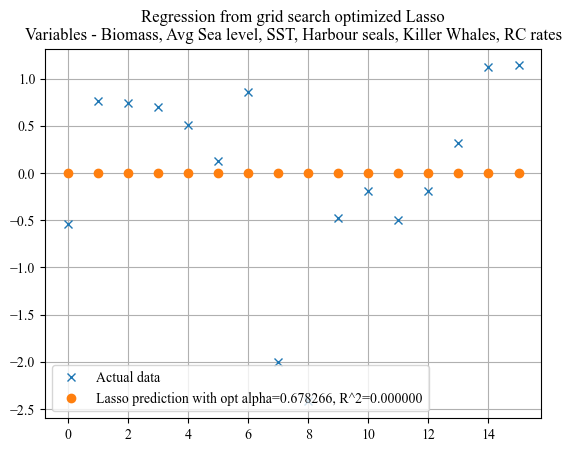

In [501]:
lasso.set_params(alpha=gscv.best_params_['alpha'])
lasso.fit(x_nrm, y_bqc)
print("Optimized mse",mse(y_bqc, lasso.predict(x_nrm)))
#print(lasso.alpha_)
print("Optimized lasso score",lasso.score(x_nrm,y_bqc))
print(lasso.coef_)

plt.figure()
plt.title("Regression from grid search optimized Lasso\n"
           "Variables - Biomass, Avg Sea level, SST, Harbour seals, Killer Whales, RC rates")
plt.plot(y_bqc,"x",label = 'Actual data')
plt.grid()
plt.plot(lasso.predict(x_nrm),"o",label = 'Lasso prediction with opt alpha=%0.6f, R^2=%0.6f'%(gscv.best_params_['alpha'],lasso.score(x_nrm,y_bqc)))
plt.legend(loc = 'best')
plt.savefig("Graphs/Big_Qualicum_Coho_prediction_grid_search_8_variables")

### Using LassoCV from sklearn linear model

In [485]:
lassocv = LassoCV(alphas = alphas, cv = 3, max_iter = 100000)
lassocv.fit(x_nrm, y_bqc)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(x_nrm, y_bqc)
print(mse(y_bqc, lasso.predict(x_nrm)))
print(lassocv.alpha_)
print(lasso.score(x_nrm,y_bqc))
print(lasso.coef_)

0.9101115252717182
0.43203606315600057
0.08988847472828199
[ 0.0938381  0.        -0.         0.         0.        -0.
 -0.       ]


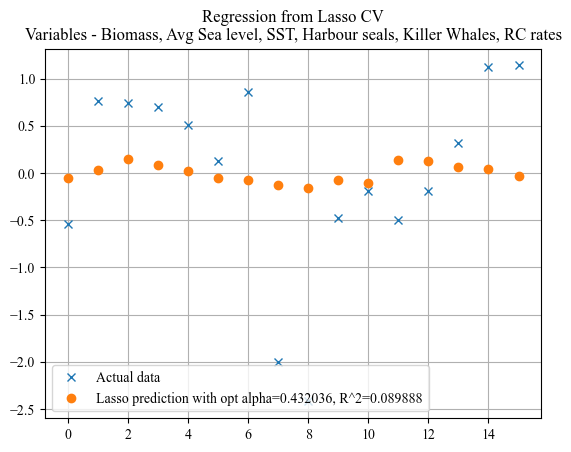

In [488]:
plt.figure()
plt.title("Regression from Lasso CV\n"
            "Variables - Biomass, Avg Sea level, SST, Harbour seals, Killer Whales, RC rates")
plt.plot(y_bqc,"x",label = 'Actual data')
plt.grid()
plt.plot(lasso.predict(x_nrm),"o",label = 'Lasso prediction with opt alpha=%0.6f, R^2=%0.6f'%(lassocv.alpha_,lasso.score(x_nrm,y_bqc)))
plt.legend(loc = 'best')
plt.savefig("Graphs/Cowichan_Chinook_prediction_Lasso_CV_search_8_variables")